In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

sns.set_context("paper")
sns.set_style("whitegrid")
import matplotlib.pyplot as plt

plt.rcParams["svg.fonttype"] = "none"
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

sns.set_color_codes()
from glob import glob
from itertools import product
import pickle

/home/stefan/.conda/envs/pts/lib/python3.8/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/home/stefan/.conda/envs/pts/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
target_vars = ["BMag_ha", "V_ha"]

In [3]:
bias_correct_splits = ["val", "train"]

In [4]:
# choose one of test, train, val
splits = ["train", "val", "test"]

In [5]:
models = {
    "MSENet14": (
        f"results_new/SENet14_xy_??.gpkg",
    ),
    
    "MSENet14 < 1y 100%": (
        f"results_size/SENet14_1y_xy_treeadd_??.gpkg",
    ),

    "MSENet14 < 1y 75%": (
        f"results_size/SENet14_75_1y_xy_treeadd_??.gpkg",
    ),    

    "MSENet14 < 1y 50%": (
        f"results_size/SENet14_50_1y_xy_treeadd_??.gpkg",
    ),

    "MSENet14 < 1y 25%": (
        f"results_size/SENet14_25_1y_xy_treeadd_??.gpkg",
    ),

    "MSENet14 < 1y 12.5%": (
        f"results_size/SENet14_12_1y_xy_treeadd_??.gpkg",
    ),

    "MSENet14 < 1y 6.25%": (
        f"results_size/SENet14_6_1y_xy_treeadd_??.gpkg",
    ),
}

In [7]:
with open('results_size.pickle', 'rb') as handle:
    results = pickle.load(handle)

In [9]:
# set number of instance
results["MSENet14"].eval("n_samples = 4270", inplace=True)
results["MSENet14 < 1y 100%"].eval("n_samples = 2636", inplace=True)
results["MSENet14 < 1y 75%"].eval("n_samples = 1977", inplace=True)
results["MSENet14 < 1y 50%"].eval("n_samples = 1318", inplace=True)
results["MSENet14 < 1y 25%"].eval("n_samples = 659", inplace=True)
results["MSENet14 < 1y 12.5%"].eval("n_samples = 330", inplace=True)
results["MSENet14 < 1y 6.25%"].eval("n_samples = 165", inplace=True)

# Bias correction

In [11]:
# get bias correction
# we do not include the 0 predictions into the adjustment since they come from a different data distribution

deltas = {}
results_corrected = {}
exclude_1y = False
exclude_pred_0 = False
clip_0 = False
for model in models:
    if "treeval" in model: # using the original correction
        continue
    corrected = []
    corrected_treeval = []
    for run in pd.unique(results[model]["run"]):
        print(model, run)
        pred_vars = [f"{v}_pred" for v in target_vars]
        preds_cal = pd.concat(
            [
                results[model].query(f"(run == {run}) & (split == @split)")
                for split in bias_correct_splits
            ],
            axis=0,
        )[target_vars + pred_vars + ["mask", "temp_diff_years"] ].copy(deep=True)            
        
        #reds_cal = preds_cal.sample(len(preds_cal))
        
        mask = np.ones_like(preds_cal["mask"])
        if exclude_1y:
            mask &= (preds_cal["temp_diff_years"] <= 1)
        if exclude_pred_0:
            mask &= ~preds_cal["mask"]
            
        correct_ = ~mask == (preds_cal[target_vars] == 0).any(axis=1)
        print(correct_.sum() / len(correct_))
        #print(f"num vals != 0: {mask.sum()}")
        y_cal_ = preds_cal[target_vars][mask].values
        preds_cal_ = preds_cal[pred_vars][mask].values

        '''
        ds = []
        num_vals = 100
        for i in range(0, len(y_cal_), num_vals):
            mm = np.ones(len(y_cal_), dtype=bool)
            mm[i:i+num_vals] = False
            ds.append((
                y_cal_[mm].astype(np.float64).sum(0)
                - preds_cal_[mm].astype(np.float64).sum(0)
            ) / (mm.sum()))
        delta = np.median(ds, 0)
        '''
        delta = (y_cal_.astype(np.float64).sum(0)
                - preds_cal_.astype(np.float64).sum(0)) / (len(y_cal_))
        deltas[model, run] = delta
        
        # check if calibration is close to 0 on calibration set
        assert np.isclose(0, y_cal_.sum(0) - ((preds_cal_ + delta).sum(0))).all() 
        
        # apply delta to all values
        df = results[model].query(f"run == {run}")[target_vars + pred_vars + ["run", "mask", "split", "n_samples"]]
        dff = df[pred_vars]
        if exclude_pred_0:
            mask = ~df[["mask"]].values
        else:
            mask = np.ones_like(df[["mask"]])
        df[pred_vars] = (dff + delta) * mask + (~mask) * dff
        if clip_0:
            df[pred_vars] = df[pred_vars].mask(dff < 0.00, 0.0)
        corrected.append(df)

    results_corrected[model] = pd.concat(corrected, axis=0)

MSENet14 0
0.9151888974556669
MSENet14 2
0.9151888974556669
MSENet14 3
0.9151888974556669
MSENet14 4
0.9151888974556669
MSENet14 5
0.9151888974556669
MSENet14 < 1y 100% 1
0.9151888974556669
MSENet14 < 1y 100% 2
0.9151888974556669
MSENet14 < 1y 100% 3
0.9151888974556669
MSENet14 < 1y 100% 4
0.9151888974556669
MSENet14 < 1y 100% 5
0.9151888974556669
MSENet14 < 1y 75% 0
0.9151888974556669
MSENet14 < 1y 75% 1
0.9151888974556669
MSENet14 < 1y 75% 2
0.9151888974556669
MSENet14 < 1y 75% 3
0.9151888974556669
MSENet14 < 1y 75% 4
0.9151888974556669
MSENet14 < 1y 50% 0
0.9151888974556669
MSENet14 < 1y 50% 1
0.9151888974556669
MSENet14 < 1y 50% 2
0.9151888974556669
MSENet14 < 1y 50% 3
0.9151888974556669
MSENet14 < 1y 50% 5
0.9151888974556669
MSENet14 < 1y 25% 1
0.9151888974556669
MSENet14 < 1y 25% 2
0.9151888974556669
MSENet14 < 1y 25% 3
0.9151888974556669
MSENet14 < 1y 25% 4
0.9151888974556669
MSENet14 < 1y 25% 5
0.9151888974556669
MSENet14 < 1y 12.5% 0
0.9151888974556669
MSENet14 < 1y 12.5% 1
0.

# Evaluation

In [12]:
def cohen_d(y1_pred, y2_pred):
    mse1 = (y1_pred**2).mean()
    mse2 = (y2_pred**2).mean()
    
    diff = mse1 - mse2
    s_pooled = np.sqrt((mse1 + mse2) / 2)
    cohens_d = diff / s_pooled
    return cohens_d

def evaluate(name, results):
    print(name)
    columns = [
        "method",
        "target",
        "R2",
        "MSE",
        "RMSE",
        "MAPE",
        "mean error",
        "mean bias",
        "rel. error",
        "n_samples",
        "run",
    ]
    results_df = []

    for target in target_vars:
        pred = target + "_pred"
        for run, result in results.groupby("run"):
            mask = mm = result[target] != 0
            #mm = result[pred] != 0
            
            results_df.append(
                pd.DataFrame(
                    [
                        [
                            name,
                            target,
                            r2_score(result[target], result[pred]),
                            mean_squared_error(
                                result[target], result[pred]
                            ),
                            mean_squared_error(
                                result[target], result[pred], squared=False
                            ),
                            mean_absolute_percentage_error(
                                result[target][mask], result[pred][mask]
                            )
                            * 100,
                            abs(
                                (result[target][mm] - result[pred][mm]).sum()
                                / len(result[pred][mm])
                            ),
                            (result[target][mm] - result[pred][mm]).sum()
                            / len(result[target][mm])
                            ,
                            abs(
                                (result[target][mm] - result[pred][mm]).sum()
                                / (result[target][mm]).sum()
                            )
                            * 100,
                            result["n_samples"].median(),
                            run,
                        ]
                    ],
                    columns=columns,
                )
            )
    results_df = pd.concat(results_df, axis=0)
    return results, results_df

'''
                            abs(
                                (result[target][mm] - result[pred][mm]).sum()
                                / len(result[pred][mm])
                            ),
                            (result[target][mm] - result[pred][mm]).sum()
                            / len(result[pred][mm])
                            ,
                            abs(
                                (result[target][mm] - result[pred][mm]).sum()
                                / (result[pred][mm]).sum()
                            )
                            * 100,
''';
'''
                            abs(
                                (result[target] - result[pred]).sum()
                                / len(result[pred])
                            ),
                            (result[target] - result[pred]).sum()
                            / len(result[pred])
                            ,
                            abs(
                                (result[target] - result[pred]).sum()
                                / (result[pred]).sum()
                            )
                            * 100,
''';

In [13]:
result_dict = {}
result_dict_corrected = {}
result_scores = {}
for split in splits:
    result_score = []
    for name in models.keys():
        # use corrected version except for linear regressor (optimal already)
        file, scores = evaluate(name, results[name].query("split == @split"))
        file.loc[:, "corrected"] = False
        scores.loc[:, "corrected"] = False

        result_dict[name] = file
        result_score.append(scores)

        file, scores = evaluate(name, results_corrected[name].query("split == @split"))
        file.loc[:, "corrected"] = True
        scores.loc[:, "corrected"] = True

        result_dict_corrected[name] = file
        result_score.append(scores)

    result_score = pd.concat(result_score, axis=0)
    result_scores[split] = result_score

MSENet14
MSENet14
MSENet14 < 1y 100%
MSENet14 < 1y 100%
MSENet14 < 1y 75%
MSENet14 < 1y 75%
MSENet14 < 1y 50%
MSENet14 < 1y 50%


/tmp/ipykernel_45615/1417926861.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file.loc[:, "corrected"] = False
/tmp/ipykernel_45615/1417926861.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file.loc[:, "corrected"] = True
/tmp/ipykernel_45615/1417926861.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

MSENet14 < 1y 25%
MSENet14 < 1y 25%
MSENet14 < 1y 12.5%
MSENet14 < 1y 12.5%
MSENet14 < 1y 6.25%
MSENet14 < 1y 6.25%
MSENet14
MSENet14


/tmp/ipykernel_45615/1417926861.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file.loc[:, "corrected"] = False
/tmp/ipykernel_45615/1417926861.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file.loc[:, "corrected"] = True
/tmp/ipykernel_45615/1417926861.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

MSENet14 < 1y 100%
MSENet14 < 1y 100%
MSENet14 < 1y 75%
MSENet14 < 1y 75%
MSENet14 < 1y 50%
MSENet14 < 1y 50%
MSENet14 < 1y 25%
MSENet14 < 1y 25%
MSENet14 < 1y 12.5%


/tmp/ipykernel_45615/1417926861.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file.loc[:, "corrected"] = False
/tmp/ipykernel_45615/1417926861.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file.loc[:, "corrected"] = True
/tmp/ipykernel_45615/1417926861.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

MSENet14 < 1y 12.5%
MSENet14 < 1y 6.25%
MSENet14 < 1y 6.25%
MSENet14
MSENet14
MSENet14 < 1y 100%
MSENet14 < 1y 100%
MSENet14 < 1y 75%
MSENet14 < 1y 75%


/tmp/ipykernel_45615/1417926861.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file.loc[:, "corrected"] = True
/tmp/ipykernel_45615/1417926861.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file.loc[:, "corrected"] = False
/tmp/ipykernel_45615/1417926861.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

MSENet14 < 1y 50%
MSENet14 < 1y 50%
MSENet14 < 1y 25%
MSENet14 < 1y 25%
MSENet14 < 1y 12.5%
MSENet14 < 1y 12.5%
MSENet14 < 1y 6.25%
MSENet14 < 1y 6.25%


/tmp/ipykernel_45615/1417926861.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file.loc[:, "corrected"] = False
/tmp/ipykernel_45615/1417926861.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file.loc[:, "corrected"] = True
/tmp/ipykernel_45615/1417926861.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

In [14]:
result_scores["test"] = result_scores["test"].query("corrected == True")

In [15]:
def abs_min(x): return x.iloc[np.argmin(abs(x))]
def abs_max(x): return x.iloc[np.argmax(abs(x))]
def abs_median(x): return np.median(abs(x))
def avg_sign(x): return np.mean(np.sign(x))
def abs_mean(x): return np.mean(abs(x))
def arg_abs_min(x): return np.argmin(abs(x))
def arg_abs_max(x): return np.argmax(abs(x))
def arg_max(x): return np.argmax(abs(x))

agg = {
    "R2": ["median", "max"],
    #'MSE' : ['median', 'min'],
    'RMSE' : ['median', 'min'],
    'MAPE' : ['median', 'min'],
    #"mean error": ["median",  "max", "min"],
    "mean bias": [abs_median,  abs_min],
    #'rel. error' : ['median', "min"],
}

rr = (
    result_scores["test"].query("target == 'BMag_ha'")
    .groupby(["target", "n_samples"])
    .agg(agg)
)

In [16]:
display(rr)

R2                 RMSE                   MAPE  \
                     median       max     median        min      median   
target  n_samples                                                         
BMag_ha 165.0      0.774840  0.777346  48.025924  47.757922  859.315691   
        330.0      0.790070  0.794887  46.373241  45.838127  956.707443   
        659.0      0.788164  0.810500  46.583353  44.059004  828.811509   
        1318.0     0.807908  0.812934  44.359387  43.775150  583.615801   
        1977.0     0.812819  0.822614  43.788657  42.627488  812.118072   
        2636.0     0.823594  0.830175  42.509563  41.709073  545.921768   
        4270.0     0.824725  0.829388  42.373149  41.805641  299.496832   

                               mean bias            
                          min abs_median   abs_min  
target  n_samples                                   
BMag_ha 165.0      337.023162   0.745173  0.130643  
        330.0      355.432665   0.611145  0.193949  
        659.0      438.979617   0.341079  0.228971  
        1318.0     189.133063   0.242115  0.200385  
        1977.0     734.521855   0.448185 -0.025055  
        2636.0     398.376741   0.219223  0.028558  
        4270.0     192.777440   0.665678 -0.290542

# Plots

In [17]:
result_scores["test"].columns = result_scores["test"].columns.map(lambda x: x.replace(' ', '_'))

In [18]:
targets = ["BMag_ha", "V_ha"]

FileNotFoundError: [Errno 2] No such file or directory: 'figures/BMag_ha_R2_size.svg'

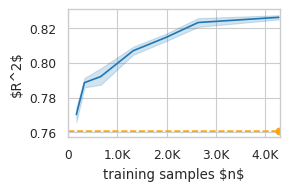

In [19]:
b_r2 = {
    "BMag_ha": 0.760720,
    "V_ha": 0.763
}

for target in targets:
    f, ax = plt.subplots(figsize=(7.48031/3, 1.5))
    sns.lineplot(x="n_samples", y="R2", data=result_scores["test"].query("target == @target"), errorbar="se", markers=["x"], dashes=False, ax=ax)
    ax.plot(np.arange(4300), [b_r2[target]] * 4300, linestyle="--",c="orange")
    ax.scatter([4270], [b_r2[target]], c="orange", label="\power{} baseline")
    ax.set_xticks(range(0, 4300, 1000), labels=[f"{n/1000}K" if n > 0 else 0 for n in range(0, 4300, 1000)])
    #ax.legend()
    ax.set_ylabel("\$R^2\$")
    ax.set_xlabel("training samples \$n\$")
    ax.set_xlim(0, 4300)
    plt.subplots_adjust(left=0.15, right=1, top=1, bottom=0.15, hspace=0.15, wspace=0.1)
    plt.savefig(f"figures/{target}_R2_size.svg")

In [ ]:
b_rmse = {
    "BMag_ha": 49.508961,
    "V_ha": 92.82
}

for target in targets:
    f, ax = plt.subplots(figsize=(7.48031/3, 1.5))
    sns.lineplot(x="n_samples", y="RMSE", data=result_scores["test"].query("target == @target"), markers=True, errorbar="se", ax=ax)
    ax.plot(np.arange(4300), [b_rmse[target]] * 4300, linestyle="--", c="orange")
    ax.scatter([4270], [b_rmse[target]], c="orange", label="\power{} baseline")
    ax.set_xlim(0, 4300)
    ax.set_xticks(range(0, 4300, 1000), labels=[f"{n/1000}K" if n > 0 else 0 for n in range(0, 4300, 1000)])
    plt.subplots_adjust(left=0.15, right=1, top=1, bottom=0.15, hspace=0.15, wspace=0.1)
    ax.set_xlabel("training samples \$n\$")
    #ax.legend()
    plt.savefig(f"figures/{target}_RMSE_size.svg")

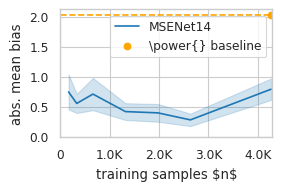

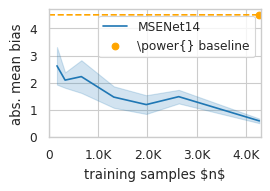

In [22]:
b_mbias = {
    "BMag_ha": 2.03,
    "V_ha": 4.50
}
ticks = {
    "BMag_ha": np.arange(0, 2.1, .5),
    "V_ha": np.arange(0, 4.6, 1)
}

for target in targets:
    f, ax = plt.subplots(figsize=(7.48031/3, 1.5))
    sns.lineplot(x="n_samples", y="mean_bias", data=result_scores["test"].query("target == @target").eval("mean_bias = abs(mean_bias)"), markers=True, errorbar="se", ax=ax, label="MSENet14")
    ax.plot(np.arange(4300), [b_mbias[target]] * 4300, linestyle="--", c="orange")
    ax.scatter([4270], [b_mbias[target]], c="orange", label="\power{} baseline")
    ax.set_xticks(range(0, 4300, 1000), labels=[f"{n/1000}K" if n > 0 else 0 for n in range(0, 4300, 1000)])
    ax.set_yticks(ticks[target])
    ax.set_ylabel("abs. mean bias")
    ax.set_xlabel("training samples \$n\$")
    ax.set_xlim(0, 4300)
    ax.legend()
    plt.subplots_adjust(left=0.15, right=1, top=1, bottom=0.15, hspace=0.15, wspace=0.1)
    #plt.savefig(f"figures/{target}_mbias_size.svg")

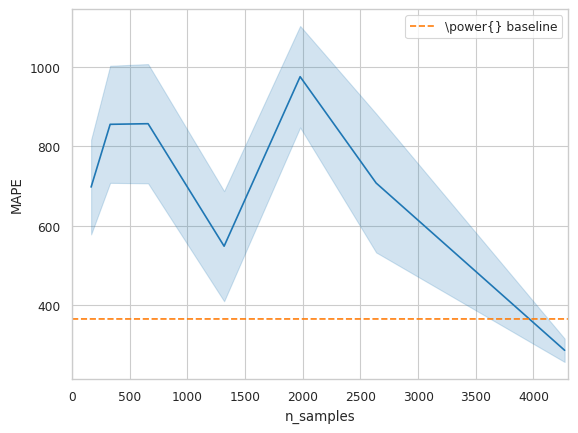

In [23]:
sns.lineplot(x="n_samples", y="MAPE", data=result_scores["test"].query("target == 'BMag_ha'"), markers=True, errorbar="se")
plt.plot(np.arange(4300), [365.34] * 4300, linestyle="--", label="\power{} baseline")
plt.xlim(0, 4300)
plt.legend()